In [1]:
#Handle Imports
import cv2
import numpy as np
import math
import pylab as pl
import matplotlib.pyplot as plt
import random

from os import listdir
from os.path import isfile, join
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

from __future__ import print_function
np.random.seed(1337)  # for reproducibility

%matplotlib inline

Using TensorFlow backend.


In [2]:
#from sklearn.model_selection import train_test_split

In [3]:
#X_train, X_test, y_train, y_test = train_test_split(
#...     X, y, test_size=0.33, random_state=42)

In [4]:
import os
for filename in os.listdir("Positives/"):
        print(filename)
        if filename.endswith('.jpg'):
            newpath = 'Positives/' + filename 
            img = cv2.imread(newpath ,0)
            print(img)
            rows, cols = img.shape
        for x in range(4):
            if filename.endswith('.jpg'):				
                cv2.imwrite(os.path.join(os.path.join('Positives/', 'data'), filename  + '_' + str(x * 90) + '.jpg'),img)
                M = cv2.getRotationMatrix2D((cols/2, rows/2), 90, 1)
                img = cv2.warpAffine(img, M, (cols,rows))

2_08.jpg
[[100 107  91 ...,  98  96  76]
 [ 74  95  99 ..., 117  98  94]
 [ 85  91  98 ..., 102  94  95]
 ..., 
 [ 91  97  86 ...,  92  87 106]
 [ 91 120 104 ...,  82 127  83]
 [102  99 112 ..., 105  82  91]]
3_13.jpg
[[107  98  97 ...,  94  97  82]
 [ 72 111  87 ...,  98  95 107]
 [124  78  90 ...,  83 102  84]
 ..., 
 [126 100  89 ..., 103  92 114]
 [110 110  83 ...,  92  78 108]
 [ 78  81 109 ...,  99  81 109]]
1_12.jpg
[[ 94  93  96 ..., 102  96  90]
 [ 93  92 112 ...,  95  96 117]
 [ 95  84  92 ...,  98 104  85]
 ..., 
 [ 94 109  75 ...,  93  97  80]
 [101  91 121 ...,  88  83 107]
 [ 91 107  88 ...,  99 100  93]]
1_14.jpg
[[ 95  89  97 ...,  75 112  80]
 [117 112 116 ..., 103 101  94]
 [ 68  96 102 ...,  90 104  86]
 ..., 
 [108  75  95 ..., 103  69  78]
 [103  78 109 ..., 104 102  97]
 [ 97  68  89 ...,  82  80 120]]
data
6_25.jpg
[[ 98 100  89 ...,  96  99  95]
 [109  96 108 ..., 107 111 111]
 [124  94  93 ...,  78 111 108]
 ..., 
 [ 91 106 100 ..., 106 104 103]
 [ 73 129  98 .

In [5]:
'''
This module will handle pre-processing such as labeling inages as positives and negatives.  If you would like to use
the data from the folders just download them and change the paths.
'''

#Read all images from folder.
pospath = "Positives/data/"
positives = [f for f in listdir(pospath) if isfile(join(pospath, f))]

negpath = "Negatives/"
negatives = [f for f in listdir(negpath) if isfile(join(negpath, f))]

#create array to hold all data
numImages = len(positives) + len(negatives)
data = np.zeros((numImages, 1025))

#choose 80/20 ratio for splitting data because of Pareto principle
split = math.floor(numImages * 0.8)

#load Positives
for i in range(len(positives)):
    path = pospath + positives[i]
    particle = cv2.imread(path )
    particle = cv2.cvtColor(particle, cv2.COLOR_BGR2GRAY)
    
    particle = particle.flatten()
    particle = np.insert(particle, 1024, 1)
    data[i] = particle
    
#load Negatives
for i in range(len(negatives)):
    path = negpath + negatives[i]
    particle = cv2.imread(path)
    particle = cv2.cvtColor(particle, cv2.COLOR_BGR2GRAY)
    
    particle = particle.flatten()
    particle = np.insert(particle, 1024, 0)
    data[len(positives) + i] = particle

#shuffle examples
np.random.shuffle(data)
data = data.astype('float32')
#split data into training and testing sets
X_train = data[int(0):int(split), int(0):int(1024)]
y_train = data[int(0):int(split), int(1024)]
X_test = data[int(split):,int(0):int(1024)]
y_test = data[int(split):, int(1024)]

#reshape images to be routed to classifier
X_train = np.reshape(X_train, (int(split), 32, 32))
X_test = np.reshape(X_test, (numImages - int(split), 32, 32))



In [6]:
X_train.shape[0]

137

In [7]:
'''This module will set up hyper parameters and  normalize the data'''

batch_size = 10
nb_classes = 2
nb_epoch = 80

# input image dimensions
img_rows, img_cols = 32, 32
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train.astype('int'), nb_classes)
Y_test = np_utils.to_categorical(y_test.astype('int'), nb_classes) 

X_train shape: (137, 32, 32, 1)
137 train samples
35 test samples


In [8]:
'''Model creation and fitting'''

model = Sequential()

model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])



Train on 137 samples, validate on 35 samples
Epoch 1/80
137/137 [==============================] - 0s - loss: 0.5899 - acc: 0.7664 - val_loss: 0.6459 - val_acc: 0.7143

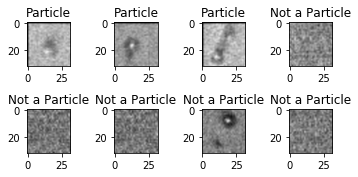

In [9]:
'''Visualize Predictions'''

fig = plt.figure()
fig.subplots_adjust(hspace=1)

predictions = model.predict_classes(X_test, batch_size=32, verbose=0)

displays = 8

for i in range(displays):
    x = random.sample(xrange(1,len(X_test)), displays)
    img = np.squeeze(X_test[x[i]])
    ax = plt.subplot(341 + i)
    if(predictions[x[i]] == 1):
        ax.set_title("Particle")
    else:
        ax.set_title("Not a Particle")
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')

plt.show()

In [10]:
predictions1 = model.predict_classes(X_test[0:1,int(0):int(1024)], batch_size=1, verbose=0)

In [11]:
predictions1[0]

0

In [12]:
import numpy as np
import sys
import cv2



class SlidingWindow(object):

    def __int__(self, blc, image, classifier, shift_r, shift_d):

        self.blc = blc
        self.image = image
        self.classifier = classifier
        self.shift_r = shift_r
        self.shift_d = shift_d

        """"
        BLC : Bottom Left Corner : This indicates the start point of the sliding window and takes in a value such as 32
        Image : This is the image that will be passed as a numpy array
        Classifier : This is the reference from the CNN handling the identification
        ShiftR : Shift Right : This is how many pixels the image will shift to the right
        ShiftD : Shift Down : This is how many pixels the image will shift down
        """


    def move_slider(self):

        count_x = 0  # number to increase each iteration of while
        count_y = 0
        shape_of_array = np.shape(self.image)  # the dimensions of the numpy Image array

        max_x = shape_of_array[1]  # the dimension along the x axis
        print( max_x)
        max_y = shape_of_array[0]  # the dimension along the y axis
        print( max_y)

        slice_obj = (slice(0, self.blc-1, 1), slice(0, self.blc-1, 1))  # sets the slice of 0 to the BLC of each axis
        sub_image = self.image[slice_obj]  # gets the pixel values from the 0 index to the max index of the passed BLC

        blc_x = self.blc
        blc_y = self.blc
        count_yes = 1
        dirname = 'Observed'

        while blc_y < max_y:

            # first run through starts at 0,0 and has a BLC of what was passed in i.e. 32x32
            # once that has run through this while loop lowers the sub_image(0, ShiftD)

            start_y = count_y * self.shift_d  # where the index of the array should start
            end_y = self.blc - 1 + (count_y * self.shift_d)  # where the index of the array for y should end

            new_y_range = (slice(start_y, end_y, 1))
            # new_y_range is the slice of the y axis from the start of the count to the BLC provided


            while blc_x < max_x:

                # as stated the first run through the top left sets to 0,0
                # in this case the window will slide to the right a number of pixels equal to shift_r

                # first iteration: (0, 0) through (31, 31)
                # second iteration: (shiftR, 0) through (31+ShiftR, 32)

                start_x = count_x * self.shift_r  # where the index of the array should start
                end_x = self.blc - 1 + (count_x * self.shift_r)  # where the index of the array for y should end

                new_x_range = (slice(start_x, end_x, 1))
                # new_x_dim is the slice of the y axis from the start of the count to the BLC provided

                slice_obj = (new_x_range, new_y_range)

                sub_image = self.image[slice_obj]

                c = classifier
                shape_of_sub_array = np.shape(sub_image)
                c.image=sub_image
                if(sub_image.shape == (32L, 32L) ):
                    myparticle = sub_image.flatten()
                    #myparticle = np.insert(myparticle, 1024, 1)
                    myparticle = myparticle.reshape(1,  img_rows, img_cols, 1)
                    myparticle = myparticle.astype('float32')
                    myparticle /= 255
                    
                    mypredictions = model.predict_classes(myparticle, batch_size=1, verbose=0)
                    if(mypredictions[0] == 1):
                        print('found one at X: ' ,start_x, 'and Y: ' , start_y)
                        file_name = '{}_yes.jpg'.format(count_yes)  # sets the name of each image to a new name inline with count_yes
                        cv2.imwrite(os.path.join(dirname, file_name), sub_image)  # writes the image to a new image with name file_name
                        count_yes += 1  # increments the count change the file name
                        
                    #if(mypredictions[0] == 0):
                        #print('found none at X: ',  start_x, 'and Y: ' ,start_y)
                        
                clone = self.image.copy()
                #cv2.rectangle(clone, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
                cv2.imshow("Window", clone)
                cv2.waitKey(1)
                #time.sleep(0.025)

                # output_string = "{}\n".format(c.c())
                # sys.stdout.write(output_string)
                # sys.stdout.flush()

                count_x += 1
                blc_x = self.blc + (count_x * self.shift_r)

            count_y += 1
            if blc_y < max_y:
                blc_y = self.blc + (count_y * self.shift_d)

            if blc_x >= max_x:
                blc_x = self.blc
                count_x = 0
                







In [13]:
class classifier:

    def __int__(self, image):
        self.image = image


    def c(self):
        percent = 10
        prob = random.randrange(0,100)
        if prob > percent:
            return False
        else:
            return True

In [14]:
'''class classifier:

    def __int__(self, image):
        self.image = image


    def c(self):
        predictions = model.predict_classes(X_test, batch_size=32, verbose=0)
        percent = 10
        prob = random.randrange(0,100)
        if prob > percent:
            return False
        else:
            return True'''

'class classifier:\n\n    def __int__(self, image):\n        self.image = image\n\n\n    def c(self):\n        predictions = model.predict_classes(X_test, batch_size=32, verbose=0)\n        percent = 10\n        prob = random.randrange(0,100)\n        if prob > percent:\n            return False\n        else:\n            return True'

In [15]:
import time
import random
import pprint
import numpy as np
import sys
import cv2
import os



class SlidingWindow(object):

    def __int__(self, blc, image, classifier, shift_r, shift_d):

        self.blc = blc
        self.image = image
        self.classifier = classifier
        self.shift_r = shift_r
        self.shift_d = shift_d

        """"
        BLC : Bottom Left Corner : This indicates the start point of the sliding window and takes in a value such as 32
        Image : This is the image that will be passed as a numpy array
        Classifier : This is the reference from the CNN handling the identification
        ShiftR : Shift Right : This is how many pixels the image will shift to the right
        ShiftD : Shift Down : This is how many pixels the image will shift down
        """


    def move_slider(self):

        count_x = 0  # number to increase each iteration of while
        count_y = 0
        shape_of_array = np.shape(self.image)  # the dimensions of the numpy Image array

        max_x = shape_of_array[1]  # the dimension along the x axis
        print( max_x)
        max_y = shape_of_array[0]  # the dimension along the y axis
        print( max_y)

        slice_obj = (slice(0, self.blc-1, 1), slice(0, self.blc-1, 1))  # sets the slice of 0 to the BLC of each axis
        sub_image = self.image[slice_obj]  # gets the pixel values from the 0 index to the max index of the passed BLC

        blc_x = self.blc
        blc_y = self.blc
        
        count_yes = 1
        dirname = 'Observed'


        while blc_y < max_y:

            # first run through starts at 0,0 and has a BLC of what was passed in i.e. 32x32
            # once that has run through this while loop lowers the sub_image(0, ShiftD)

            start_y = count_y * self.shift_d  # where the index of the array should start
            end_y = self.blc - 1 + (count_y * self.shift_d)  # where the index of the array for y should end

            new_y_range = (slice(start_y, end_y, 1))
            # new_y_range is the slice of the y axis from the start of the count to the BLC provided


            while blc_x < max_x:

                # as stated the first run through the top left sets to 0,0
                # in this case the window will slide to the right a number of pixels equal to shift_r

                # first iteration: (0, 0) through (31, 31)
                # second iteration: (shiftR, 0) through (31+ShiftR, 32)

                start_x = count_x * self.shift_r  # where the index of the array should start
                end_x = self.blc - 1 + (count_x * self.shift_r)  # where the index of the array for y should end

                new_x_range = (slice(start_x, end_x, 1))
                # new_x_dim is the slice of the y axis from the start of the count to the BLC provided

                slice_obj = (new_x_range, new_y_range)

                sub_image = self.image[slice_obj]

                c = classifier
                shape_of_sub_array = np.shape(sub_image)
                c.image=sub_image
                
                if(sub_image.shape == (32L, 32L) ):
                    
                    myparticle = sub_image.flatten()
                    #myparticle = np.insert(myparticle, 1024, 1)
                    myparticle = myparticle.reshape(1,  img_rows, img_cols, 1)
                    myparticle = myparticle.astype('float32')
                    myparticle /= 255
                    
                    
                    
                    mypredictions = model.predict_classes(myparticle, batch_size=1, verbose=0)
                    if(mypredictions[0] == 1):
                        print('found one at X: ' ,start_x, 'and Y: ' , start_y)
                        
                        ## added 3/24 @ 4:45 pm - Matt
                        file_name = '{}_yes.jpg'.format(count_yes)  # sets the name of each image to a new name inline with count_yes
                        cv2.imwrite(os.path.join(dirname, file_name), sub_image)  # writes the image to a new image with name file_name
                        count_yes += 1  # increments the count change the file name
                        cv2.rectangle(self.image, (start_x, start_y), (end_x, end_y), (0, 255, 0), 1) # shows a box aroudn the coordinates where it detects a particle
                    #if(mypredictions[0] == 0):
                    #    print('found none at X: ',  start_x, 'and Y: ' ,start_y)
                        
                        
                clone = self.image.copy()
                cv2.rectangle(clone, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
                cv2.imshow("Window", clone)
                cv2.waitKey(1)
                #time.sleep(0.025)

                # output_string = "{}\n".format(c.c())
                # sys.stdout.write(output_string)
                # sys.stdout.flush()

                count_x += 1
                blc_x = self.blc + (count_x * self.shift_r)

            count_y += 1
            if blc_y < max_y:
                blc_y = self.blc + (count_y * self.shift_d)

            if blc_x >= max_x:
                blc_x = self.blc
                count_x = 0
                




'''


class Driver():

    def main(self):

        # image = np.random.rand(256, 256)
        # np.set_printoptions(precision=3, threshold=256, edgeitems=128, linewidth=256)
        # pprint.pprint(image)

        im = cv2.imread('1.jpg', 0)
        print( type(im))

        blc = 33
        c = classifier()
        c.image=im
        shift_r = 30
        shift_d = 30

        s_w = SlidingWindow()
        s_w.blc=blc
        s_w.image=im
        s_w.classifier=c
        s_w.shift_r=shift_r
        s_w.shift_d=shift_d

        s_w.move_slider()




if __name__ == '__main__':
    Driver().main()'''

"\n\n\nclass Driver():\n\n    def main(self):\n\n        # image = np.random.rand(256, 256)\n        # np.set_printoptions(precision=3, threshold=256, edgeitems=128, linewidth=256)\n        # pprint.pprint(image)\n\n        im = cv2.imread('1.jpg', 0)\n        print( type(im))\n\n        blc = 33\n        c = classifier()\n        c.image=im\n        shift_r = 30\n        shift_d = 30\n\n        s_w = SlidingWindow()\n        s_w.blc=blc\n        s_w.image=im\n        s_w.classifier=c\n        s_w.shift_r=shift_r\n        s_w.shift_d=shift_d\n\n        s_w.move_slider()\n\n\n\n\nif __name__ == '__main__':\n    Driver().main()"

In [16]:
im = cv2.imread('1.jpg', 0)
print( type(im))

blc = 33
c = classifier()
c.image=im
shift_r = 32
shift_d = 32
s_w = SlidingWindow()
s_w.blc=blc
s_w.image=im
s_w.classifier=c
s_w.shift_r=shift_r
s_w.shift_d=shift_d
s_w.move_slider()

<type 'numpy.ndarray'>
1280
960
found one at X:  384 and Y:  128
found one at X:  384 and Y:  160
found one at X:  384 and Y:  320
found one at X:  128 and Y:  384
found one at X:  160 and Y:  384
found one at X:  192 and Y:  384
found one at X:  320 and Y:  384
found one at X:  352 and Y:  384
found one at X:  896 and Y:  736
found one at X:  928 and Y:  736
found one at X:  800 and Y:  800
found one at X:  832 and Y:  800
found one at X:  864 and Y:  800
found one at X:  896 and Y:  800
found one at X:  928 and Y:  800
found one at X:  768 and Y:  832
found one at X:  800 and Y:  832
found one at X:  832 and Y:  832
found one at X:  864 and Y:  832
found one at X:  896 and Y:  832
found one at X:  928 and Y:  832
found one at X:  800 and Y:  864
found one at X:  832 and Y:  864
found one at X:  864 and Y:  864
found one at X:  896 and Y:  864
found one at X:  928 and Y:  864
found one at X:  736 and Y:  896
found one at X:  768 and Y:  896
found one at X:  800 and Y:  896
found one a